In [1]:
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
# from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings('ignore')

In [2]:
data = sm.datasets.co2.load_pandas()

In [3]:
df = data.data

In [4]:
df.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [5]:
df = df['co2'].resample('MS').mean()

In [6]:
df.head()

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01           NaN
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

In [7]:
df.isnull().sum()

5

In [8]:
df = df.fillna(df.bfill())

In [9]:
df.isnull().sum()

0

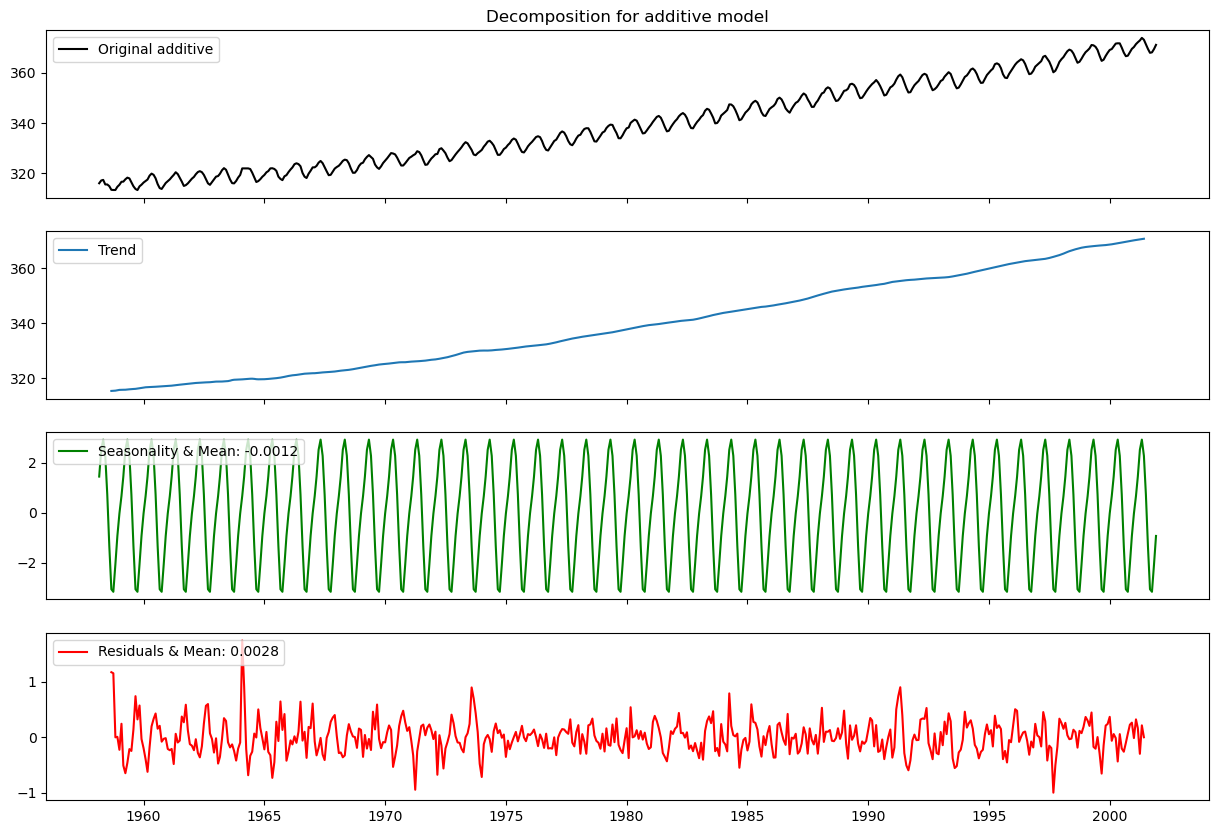

In [10]:
def ts_decompose(dataframe, model="additive", stationary=False):
    result = seasonal_decompose(dataframe, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(dataframe, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)
    
ts_decompose(df)

In [11]:
train = df[:'1997-12-01']
test = df['1998-01-01':]

In [12]:
# ARIMA(p, d, q): (Autoregressive Integrated Moving Average)

In [13]:
arima_model = ARIMA(train, order=(1, 1, 1)).fit()

In [14]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    co2   No. Observations:                  478
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -575.768
Date:                Sat, 22 Jul 2023   AIC                           1157.537
Time:                        01:12:20   BIC                           1170.039
Sample:                    03-01-1958   HQIC                          1162.452
                         - 12-01-1997                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5669      0.054     10.586      0.000       0.462       0.672
ma.L1          0.3284      0.062      5.306      0.000       0.207       0.450
sigma2         0.6534      0.050     12.965      0.000       0.555       0.752
===================================================================================
Ljung-Box (L1) (Q):                   2.26   Jarque-Bera (JB):                 3.96
Prob(Q):                              0.13   Prob(JB):                         0.14
Heteroskedasticity (H):               0.98   Skew:                             0.09
Prob(H) (two-sided):                  0.89   Kurtosis:                         2.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
y_pred = arima_model.forecast(48)
y_pred.head()

1998-01-01    365.558639
1998-02-01    366.300479
1998-03-01    366.721012
1998-04-01    366.959404
1998-05-01    367.094543
Freq: MS, Name: predicted_mean, dtype: float64

In [16]:
def plot_co2(train, test, y_pred, title):
    mae = mean_absolute_error(test, y_pred)
    train["1985":].plot(legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae,2)}")
    test.plot(legend=True, label="TEST", figsize=(6, 4))
    y_pred.plot(legend=True, label="PREDICTION")
    plt.show(block=True)

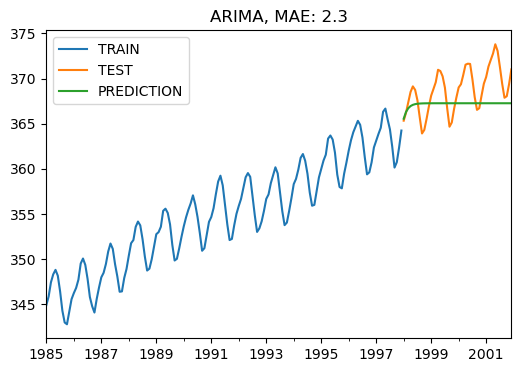

In [17]:
plot_co2(train, test, y_pred, "ARIMA")

In [18]:
# Hyperparameter Optimization

In [19]:
# AIC & BIC

In [20]:
p = d = q = range(1, 4)
pdq = list(itertools.product(p, d, q))

In [21]:
def arima_optimizer_aic(train, orders):
    best_aic, best_params = float("inf"), None
    for order in orders:
        try:
            arima_model_result = ARIMA(train, order=order).fit()
            aic = arima_model_result.aic
            if aic < best_aic:
                best_aic, best_params = aic, order
            print('ARIMA%s AIC=%.2f' % (order, aic))
        except:
            continue
    print('Best ARIMA%s AIC=%.2f' % (best_params, best_aic))
    return best_params

In [22]:
best_params_aic = arima_optimizer_aic(train, pdq)

ARIMA(1, 1, 1) AIC=1157.54
ARIMA(1, 1, 2) AIC=1113.98
ARIMA(1, 1, 3) AIC=1095.90
ARIMA(1, 2, 1) AIC=1257.80
ARIMA(1, 2, 2) AIC=1161.11
ARIMA(1, 2, 3) AIC=1117.55
ARIMA(1, 3, 1) AIC=1262.06
ARIMA(1, 3, 2) AIC=1263.84
ARIMA(1, 3, 3) AIC=1253.50
ARIMA(2, 1, 1) AIC=979.80
ARIMA(2, 1, 2) AIC=979.50
ARIMA(2, 1, 3) AIC=842.97
ARIMA(2, 2, 1) AIC=1107.02
ARIMA(2, 2, 2) AIC=1119.91
ARIMA(2, 2, 3) AIC=1069.79
ARIMA(2, 3, 1) AIC=1263.24
ARIMA(2, 3, 2) AIC=1263.81
ARIMA(2, 3, 3) AIC=1126.80
ARIMA(3, 1, 1) AIC=979.82
ARIMA(3, 1, 2) AIC=980.66
ARIMA(3, 1, 3) AIC=911.01
ARIMA(3, 2, 1) AIC=1052.76
ARIMA(3, 2, 2) AIC=913.07
ARIMA(3, 2, 3) AIC=918.62
ARIMA(3, 3, 1) AIC=1216.43
ARIMA(3, 3, 2) AIC=1066.11
ARIMA(3, 3, 3) AIC=1126.52
Best ARIMA(2, 1, 3) AIC=842.97


In [23]:
best_params_aic

(2, 1, 3)

In [24]:
arima_model = ARIMA(train, order=best_params_aic).fit()

In [25]:
y_pred = arima_model.forecast(48)
y_pred.head()

1998-01-01    365.543892
1998-02-01    366.389222
1998-03-01    366.833635
1998-04-01    366.768092
1998-05-01    366.221192
Freq: MS, Name: predicted_mean, dtype: float64

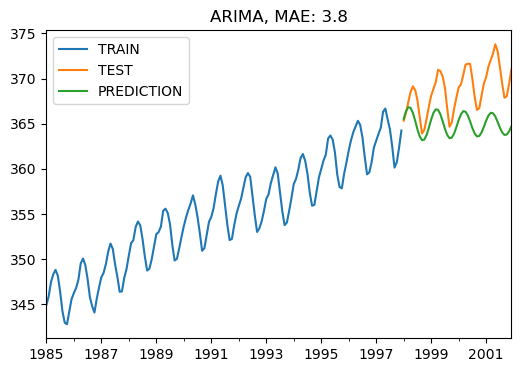

In [26]:
plot_co2(train, test, y_pred, "ARIMA")

In [27]:
def arima_optimizer_mae(train, orders):
    best_mae, best_orders = float("inf"), None
    for order in orders:
        try:
            arima_model_result = ARIMA(train, order=order).fit()
            y_pred = arima_model_result.forecast(48)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_mae, best_orders = mae, order
            print('ARIMA%s MAE=%.2f' % (order, mae))
        except:
            continue
    print('Best ARIMA%s MAE=%.2f' % (best_orders, best_mae))
    return best_orders

In [28]:
best_params_mae = arima_optimizer_mae(train, pdq)

ARIMA(1, 1, 1) MAE=2.30
ARIMA(1, 1, 2) MAE=3.21
ARIMA(1, 1, 3) MAE=3.34
ARIMA(1, 2, 1) MAE=42.64
ARIMA(1, 2, 2) MAE=1.81
ARIMA(1, 2, 3) MAE=1.79
ARIMA(1, 3, 1) MAE=43.55
ARIMA(1, 3, 2) MAE=43.19
ARIMA(1, 3, 3) MAE=34.60
ARIMA(2, 1, 1) MAE=4.79
ARIMA(2, 1, 2) MAE=4.73
ARIMA(2, 1, 3) MAE=3.80
ARIMA(2, 2, 1) MAE=1.99
ARIMA(2, 2, 2) MAE=32.18
ARIMA(2, 2, 3) MAE=2.40
ARIMA(2, 3, 1) MAE=42.03
ARIMA(2, 3, 2) MAE=42.76
ARIMA(2, 3, 3) MAE=32.75
ARIMA(3, 1, 1) MAE=4.75
ARIMA(3, 1, 2) MAE=4.78
ARIMA(3, 1, 3) MAE=3.52
ARIMA(3, 2, 1) MAE=2.46
ARIMA(3, 2, 2) MAE=1.99
ARIMA(3, 2, 3) MAE=2.06
ARIMA(3, 3, 1) MAE=12.37
ARIMA(3, 3, 2) MAE=2.34
ARIMA(3, 3, 3) MAE=34.50
Best ARIMA(1, 2, 3) MAE=1.79


In [29]:
arima_model = ARIMA(train, order=best_params_mae).fit()

In [30]:
y_pred = arima_model.forecast(48)
y_pred.head()

1998-01-01    365.219001
1998-02-01    365.662665
1998-03-01    365.905120
1998-04-01    366.067805
1998-05-01    366.198865
Freq: MS, Name: predicted_mean, dtype: float64

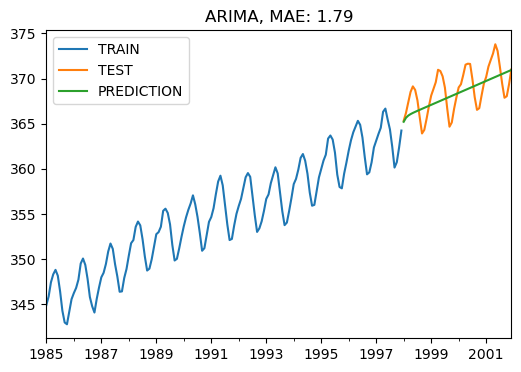

In [31]:
plot_co2(train, test, y_pred, "ARIMA")

In [32]:
# SARIMA(p, d, q): (Seasonal Autoregressive Integrated Moving-Average)

In [33]:
model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(0, 0, 0, 12))

In [34]:
sarima_model = model.fit(disp=0)

In [35]:
y_pred_test = sarima_model.get_forecast(steps=48)

In [36]:
y_pred = y_pred_test.predicted_mean
y_pred.head()

1998-01-01    365.160364
1998-02-01    365.156968
1998-03-01    365.153572
1998-04-01    365.150176
1998-05-01    365.146779
Freq: MS, Name: predicted_mean, dtype: float64

In [37]:
y_pred = pd.Series(y_pred, index=test.index)

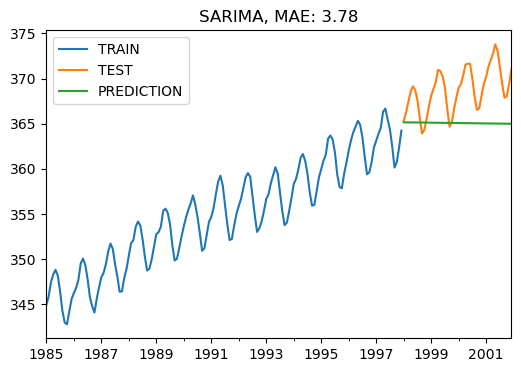

In [38]:
plot_co2(train, test, y_pred, "SARIMA")

In [39]:
p = d = q = range(0, 2)

In [40]:
pdq = list(itertools.product(p, d, q))

In [41]:
pdq[:10]

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [42]:
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [43]:
seasonal_pdq[:10]

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [44]:
def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    best_aic, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                results = sarimax_model.fit(disp=0)
                aic = results.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
                print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, aic))
            except:
                continue
    print('SARIMA{}x{}12 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    return best_order, best_seasonal_order

In [45]:
best_order, best_seasonal_order = sarima_optimizer_aic(train, pdq, seasonal_pdq)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:6922.606550808509
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6318.305219678983
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1643.9996657880379
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1428.293892535421
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1890.6354550035767
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1687.207363347325
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1205.025400970832
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:973.2077279585856
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6269.190364743509
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:5663.56792764049
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1229.844751436014
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1126.5843176744593
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1467.596754729915
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2025.119671861251
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1008.1602684931656
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:767.6332838551846
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1523.9134546907358
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1154.7

In [46]:
best_order

(1, 1, 1)

In [47]:
best_seasonal_order

(0, 1, 1, 12)

In [48]:
model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)

In [49]:
sarima_final_model = model.fit(disp=0)

In [50]:
y_pred_test = sarima_final_model.get_forecast(steps=48)

In [51]:
y_pred = y_pred_test.predicted_mean
y_pred = pd.Series(y_pred, index=test.index)

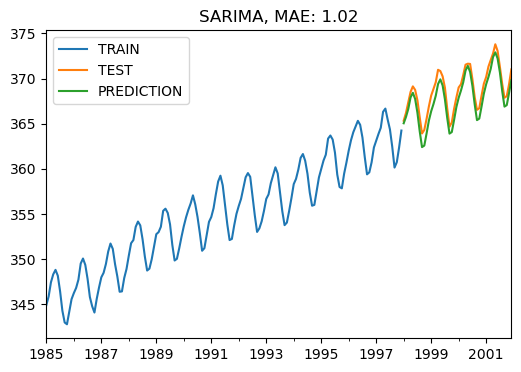

In [52]:
plot_co2(train, test, y_pred, "SARIMA")

In [53]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [54]:
def sarima_optimizer_mae(train, pdq, seasonal_pdq):
    best_mae, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                sarima_model = model.fit(disp=0)
                y_pred_test = sarima_model.get_forecast(steps=48)
                y_pred = y_pred_test.predicted_mean
                mae = mean_absolute_error(test, y_pred)
                if mae < best_mae:
                    best_mae, best_order, best_seasonal_order = mae, param, param_seasonal
                print('SARIMA{}x{}12 - MAE:{}'.format(param, param_seasonal, mae))
            except:
                continue
    print('SARIMA{}x{}12 - MAE:{}'.format(best_order, best_seasonal_order, best_mae))
    return best_order, best_seasonal_order

In [55]:
best_order, best_seasonal_order = sarima_optimizer_mae(train, pdq, seasonal_pdq)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - MAE:368.7634375
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - MAE:324.17909156740006
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - MAE:5.063020833333329
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - MAE:4.803324367909064
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - MAE:5.141627934792241
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - MAE:4.928848927436991
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - MAE:3.3237249111828717
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - MAE:1.5279594242943457
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - MAE:364.9178691427658
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - MAE:320.4050598870995
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - MAE:4.9853387451054125
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - MAE:4.765305171415889
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - MAE:4.923277286285569
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - MAE:5.047272119669656
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - MAE:3.674146750851109
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - MAE:1.56672928594917
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - MAE:4.526979166666664
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - MAE:3.93154014463

In [56]:
model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)
y_pred_test = sarima_final_model.get_forecast(steps=48)
y_pred = y_pred_test.predicted_mean
y_pred = pd.Series(y_pred, index=test.index)

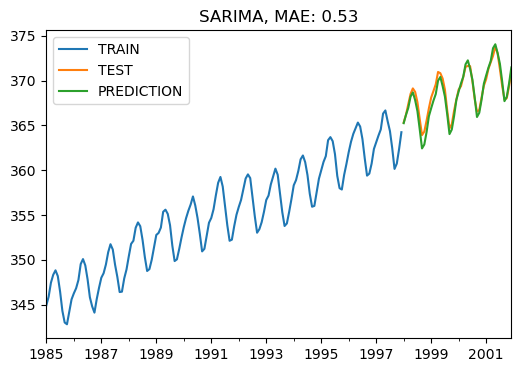

In [57]:
plot_co2(train, test, y_pred, "SARIMA")

In [59]:
model = SARIMAX(df, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)

In [60]:
forecasting = sarima_final_model.get_forecast(steps=280)

In [61]:
y_pred = forecasting.predicted_mean

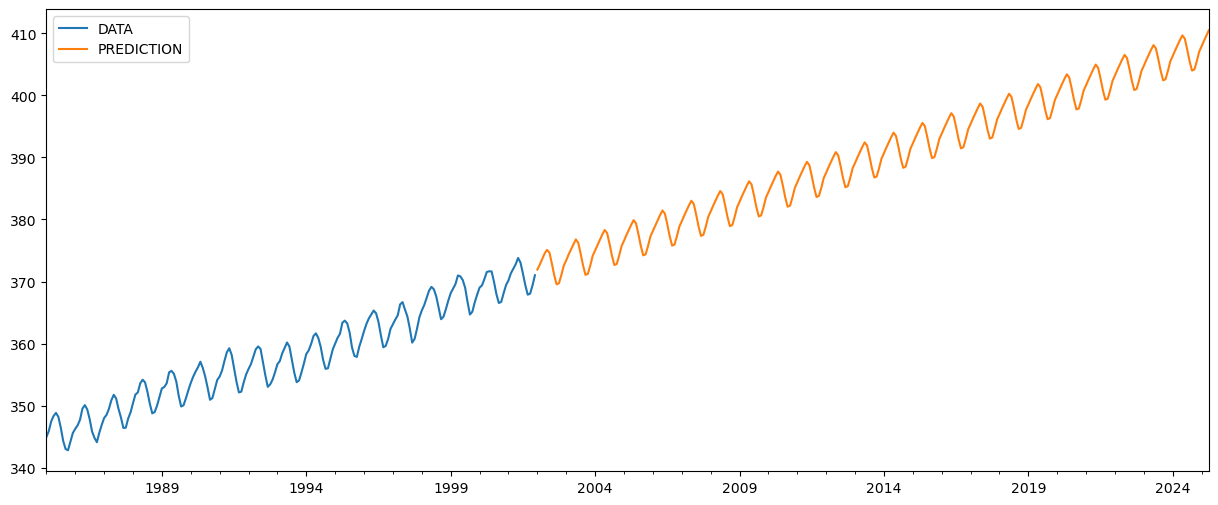

In [62]:
df["1985":].plot(legend=True, label="DATA", figsize=(15, 6))
y_pred.plot(legend=True, label="PREDICTION")
plt.show(block=True)

In [63]:
y_pred.loc["2023-07-01"]

405.84939943447336

In [64]:
y_pred["2023":]

2023-01-01    404.788595
2023-02-01    405.689642
2023-03-01    406.515455
2023-04-01    407.363543
2023-05-01    408.102012
2023-06-01    407.585913
2023-07-01    405.849399
2023-08-01    403.938387
2023-09-01    402.435662
2023-10-01    402.610360
2023-11-01    403.958846
2023-12-01    405.500507
2024-01-01    406.356069
2024-02-01    407.257116
2024-03-01    408.082929
2024-04-01    408.931017
2024-05-01    409.669486
2024-06-01    409.153387
2024-07-01    407.416873
2024-08-01    405.505861
2024-09-01    404.003136
2024-10-01    404.177834
2024-11-01    405.526320
2024-12-01    407.067981
2025-01-01    407.923543
2025-02-01    408.824590
2025-03-01    409.650403
2025-04-01    410.498491
Freq: MS, Name: predicted_mean, dtype: float64

In [65]:
df2 = pd.read_csv("current_co2_data.csv")

In [66]:
df2.head()

,Yr,Mn,Date,Date,CO2,seasonally,fit,seasonally,CO2,seasonally,Sta
0,,,,,,adjusted,,adjusted fit,filled,adjusted filled,NaN
1,,,Excel,,[ppm],[ppm],[ppm],[ppm],[ppm],[ppm],NaN
2,1958,1,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
3,1958,2,21231,1958.126,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
4,1958,3,21259,1958.2027,315.71,314.44,316.19,314.91,315.71,314.44,MLO


In [67]:
df2.tail()

,Yr,Mn,Date,Date,CO2,seasonally,fit,seasonally,CO2,seasonally,Sta
789,2023,8,45153,2023.6219,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
790,2023,9,45184,2023.7068,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
791,2023,10,45214,2023.789,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
792,2023,11,45245,2023.874,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
793,2023,12,45275,2023.9562,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO


In [68]:
df2 = df2.tail(df2.shape[0] -2)

In [69]:
df2.head()

,Yr,Mn,Date,Date,CO2,seasonally,fit,seasonally,CO2,seasonally,Sta
2,1958,1,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
3,1958,2,21231,1958.126,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
4,1958,3,21259,1958.2027,315.71,314.44,316.19,314.91,315.71,314.44,MLO
5,1958,4,21290,1958.2877,317.45,315.16,317.3,314.99,317.45,315.16,MLO
6,1958,5,21320,1958.3699,317.51,314.69,317.89,315.07,317.51,314.69,MLO


In [70]:
df2.columns

Index(['  Yr', ' Mn', '    Date', '      Date', '     CO2', 'seasonally',
       '        fit', '  seasonally', '      CO2', ' seasonally', ' Sta'],
      dtype='object')

In [71]:
df2.columns = df2.columns.str.replace(' ', '')

In [72]:
df2.columns

Index(['Yr', 'Mn', 'Date', 'Date', 'CO2', 'seasonally', 'fit', 'seasonally',
       'CO2', 'seasonally', 'Sta'],
      dtype='object')

In [73]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 792 entries, 2 to 793
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Yr          792 non-null    object
 1   Mn          792 non-null    object
 2   Date        792 non-null    object
 3   Date        792 non-null    object
 4   CO2         792 non-null    object
 5   seasonally  792 non-null    object
 6   fit         792 non-null    object
 7   seasonally  792 non-null    object
 8   CO2         792 non-null    object
 9   seasonally  792 non-null    object
 10  Sta         792 non-null    object
dtypes: object(11)
memory usage: 68.2+ KB


In [74]:
df2["Yr"] = df2["Yr"].astype(int)

In [75]:
df2["Mn"] = df2["Mn"].astype(int)

In [76]:
df2["CO2"] = df2["CO2"].astype(float)

In [77]:
df2["Date_new"] = df2["Yr"].astype(str) + "-" + df2["Mn"].astype(str) + "-" + "01"

In [78]:
df2["Date_new"] = pd.to_datetime(df2["Date_new"])

In [79]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 792 entries, 2 to 793
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Yr          792 non-null    int32         
 1   Mn          792 non-null    int32         
 2   Date        792 non-null    object        
 3   Date        792 non-null    object        
 4   CO2         792 non-null    float64       
 5   seasonally  792 non-null    object        
 6   fit         792 non-null    object        
 7   seasonally  792 non-null    object        
 8   CO2         792 non-null    float64       
 9   seasonally  792 non-null    object        
 10  Sta         792 non-null    object        
 11  Date_new    792 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int32(2), object(7)
memory usage: 68.2+ KB


In [80]:
df["2001":]

2001-01-01    370.175
2001-02-01    371.325
2001-03-01    372.060
2001-04-01    372.775
2001-05-01    373.800
2001-06-01    373.060
2001-07-01    371.300
2001-08-01    369.425
2001-09-01    367.880
2001-10-01    368.050
2001-11-01    369.375
2001-12-01    371.020
Freq: MS, Name: co2, dtype: float64

In [81]:
df2[(df2["Yr"] == 2001)]["CO2"]

,CO2,CO2
518,370.20,370.20
519,371.42,371.42
520,372.04,372.04
521,372.78,372.78
522,373.94,373.94
523,373.23,373.23
524,371.54,371.54
525,369.47,369.47
526,367.88,367.88
527,368.01,368.01


In [82]:
current_co2_data = df2[(df2["Date_new"] > "2001-12-01") & (df2["Date_new"] < "2023-07-01")][["Date_new", "CO2"]].iloc[:,0:2]

In [83]:
current_co2_data

,Date_new,CO2
530,2002-01-01,372.36
531,2002-02-01,373.00
532,2002-03-01,373.44
533,2002-04-01,374.77
534,2002-05-01,375.48
...,...,...
783,2023-02-01,420.33
784,2023-03-01,420.51
785,2023-04-01,422.73
786,2023-05-01,423.78


In [84]:
current_co2_data.set_index("Date_new", inplace=True)

In [85]:
current_co2_data.head()

,CO2
Date_new,
2002-01-01,372.36
2002-02-01,373.00
2002-03-01,373.44
2002-04-01,374.77
2002-05-01,375.48


In [86]:
current_co2_data = current_co2_data.squeeze()

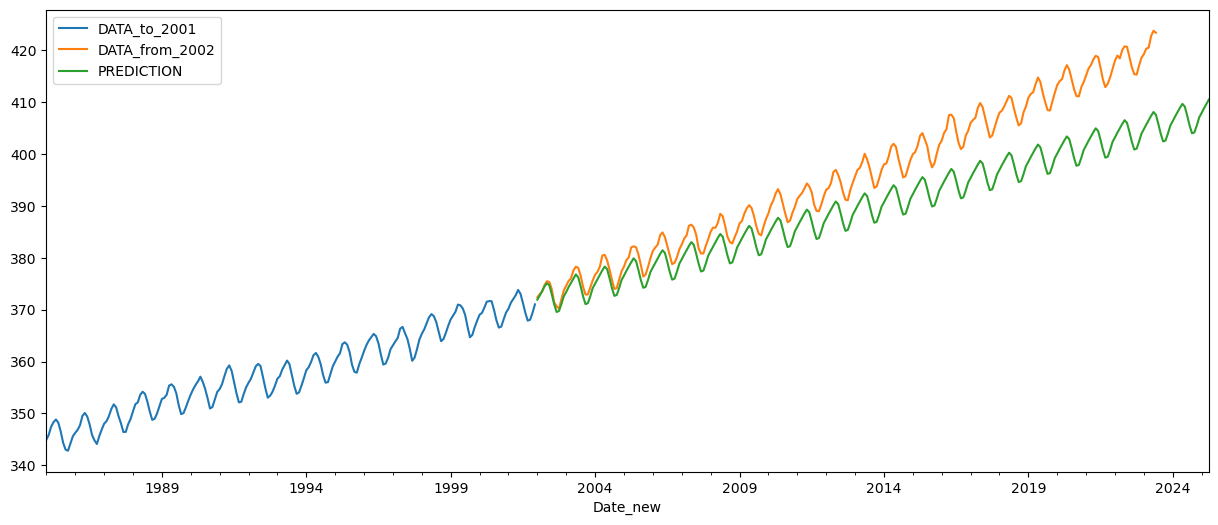

In [87]:
df["1985":].plot(legend=True, label="DATA_to_2001", figsize=(15, 6))
current_co2_data.plot(legend=True, label="DATA_from_2002")
y_pred.plot(legend=True, label="PREDICTION")
plt.show(block=True)

In [89]:
current_co2_data

Date_new
2002-01-01    372.36
2002-02-01    373.00
2002-03-01    373.44
2002-04-01    374.77
2002-05-01    375.48
               ...  
2023-02-01    420.33
2023-03-01    420.51
2023-04-01    422.73
2023-05-01    423.78
2023-06-01    423.39
Name: CO2, Length: 258, dtype: float64

In [90]:
y_pred

2002-01-01    371.930529
2002-02-01    372.718073
2002-03-01    373.585290
2002-04-01    374.494055
2002-05-01    375.101889
                 ...    
2024-12-01    407.067981
2025-01-01    407.923543
2025-02-01    408.824590
2025-03-01    409.650403
2025-04-01    410.498491
Freq: MS, Name: predicted_mean, Length: 280, dtype: float64